In [36]:
import os
import glob
import random
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms, models, datasets
from torch.optim.lr_scheduler import StepLR

from pylab import imread

In [37]:
if (os.path.exists("./output")) == False:
    os.mkdir("output")

if (os.path.exists("./model_weight")) == False:
    os.mkdir("model_weight")

for epoch in range (200):
    if (os.path.exists("./output/%03d" % epoch)) == False:
        os.mkdir("./output/%03d" % epoch)
    else:
        files = glob.glob("./output/%03d/*.png" % epoch)

        for f in files:
          os.remove(f)

# Data

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

kwargs = {'num_workers': 2, 'pin_memory': True}

cuda = True
image_size = 32
batchSize = 64

In [39]:
def show_img(source, target, source_label, target_label):
    num_row = 4
    num_col = 5
    num = 10
    images = source[:num]
    labels = source_label[:num]

    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        
        image =  images[i].transpose(0,2).transpose(0,1)

        ax.imshow(image, cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))


    images = target[:num]
    labels = target_label[:num]
    for i in range(10,20):
        ax = axes[i//num_col, i%num_col]
        image = images[i - 10].transpose(0,2).transpose(0,1)
        ax.imshow(image, cmap='gray')
        ax.set_title('Label: {}'.format(labels[i - 10]))
    plt.tight_layout()
    plt.show()

## Mnist

In [40]:
transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: t * 2 - 1)])

mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)


## Mnist-M

In [41]:
def get_backgrounds():
    backgrounds = []
    for file in os.listdir("./images/train"):
        if file.endswith('.jpg'):
            backgrounds.append(plt.imread(os.path.join("./images/train",file)))
    return backgrounds

def compose_image(image, backgrounds):
    image = (image > 0).astype(np.float32)
    image = image.reshape([28,28])*255.0
    
    image = np.stack([image,image,image],axis=2)
    
    background = np.random.choice(backgrounds)
    w,h,_ = background.shape
    dw, dh,_ = image.shape
    x = np.random.randint(0,w-dw)
    y = np.random.randint(0,h-dh)
    
    temp = background[x:x+dw, y:y+dh]
    return np.abs(temp-image).astype(np.uint8)

class MNISTM(Dataset):    
    def __init__(self, train=True,transform=None):
        if train:
            self.data = datasets.MNIST(root='.data/mnist',train=True, download=True)
        else:
            self.data = datasets.MNIST(root='.data/mnist',train=False, download=True)
        self.backgrounds = get_backgrounds()
        self.transform = transform
        self.images = []
        self.targets = []
        for index in range(len(self.data)):
            image = np.array(self.data.__getitem__(index)[0])
            target = self.data.__getitem__(index)[1]
            image = compose_image(image, self.backgrounds)
            if self.transform is not None:
                image = self.transform(image)
            self.images.append(image)
            self.targets.append(target)
        
    def __getitem__(self,index):
        image = self.images[index]
        target = self.targets[index]
        
        return image, target
        
    def __len__(self):
        return len(self.data)

In [42]:
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: t * 2 - 1)
        ])

trainset = MNISTM(train=True,transform=transform)
testset = MNISTM(train=False,transform=transform)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [43]:
source_train = DataLoader(mnist_trainset, batch_size=batchSize, shuffle=True, drop_last=True, **kwargs)
source_test = DataLoader(mnist_testset, batch_size=batchSize, shuffle=True, drop_last=True, **kwargs)

In [44]:
target_train = DataLoader(trainset, batch_size=batchSize, shuffle=True, drop_last=True, **kwargs)
target_test = DataLoader(testset, batch_size=batchSize, shuffle=False, drop_last=True, **kwargs)

In [45]:
source_iter = iter(source_train)
source_inputs, source_label = source_iter.next()

target_iter = iter(target_train)
target_inputs, target_label = target_iter.next()

In [46]:
print("%2f, %2f" % (torch.min(source_inputs), torch.max(source_inputs)))

-1.000000, 1.000000


In [47]:
print("%2f, %2f" % (torch.min(target_inputs), torch.max(target_inputs)))

-1.000000, 1.000000


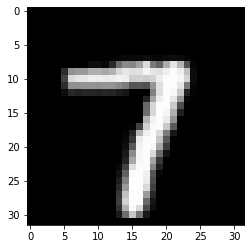

In [48]:
index = random.randint(0, 15)
image_source_sample = source_inputs[index]
image_source_sample = (image_source_sample + 1) * 0.5
image = image_source_sample.transpose(0,2).transpose(0,1)
plt.imshow(image)

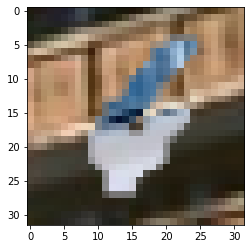

In [49]:
image_target_sample = target_inputs[index]
image_target_sample = (image_target_sample + 1) * 0.5
image = image_target_sample.transpose(0,2).transpose(0,1)
plt.imshow(image)

# Module

## Perceptual

In [50]:
class Perceptual(nn.Module):
    def __init__(self):
        super(Perceptual, self).__init__()

        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.InstanceNorm2d(3),
            nn.Tanh()
        )

    def forward(self, A, B):
        encode_A = self.encoder(A)
        encode_B = self.encoder(B)
        reconA = self.decoder(encode_A)
        reconB = self.decoder(encode_B)

        encode_A.detach()
        encode_B.detach()

        style = encode_A[:, 0:128, : , :]
        content = encode_B[:, 128:256, :, :]
        
        mixed_latent = torch.cat([style, content], dim=1)
        mixed_image = self.decoder(mixed_latent)

        return mixed_image, reconA, reconB

In [51]:
test_tensor_source = source_inputs
test_tensor_target = target_inputs

perceptual = Perceptual()
encoder = perceptual.encoder
decoder = perceptual.decoder
encoder_out = encoder(test_tensor_target)
decoder_out = decoder(encoder_out)

print(encoder_out.size())
print(decoder_out.size())

mixed, reconA, reconB = perceptual(test_tensor_source, test_tensor_target)
print(mixed.size())
print(reconA.size())
print(reconB.size())

print("mixed: min: %.2f, max: %.2f " % (torch.min(mixed), torch.max(mixed)))

print("reconA: min: %.2f, max: %.2f " % (torch.min(reconA), torch.max(reconA)))

print("reconB: min: %.2f, max: %.2f " % (torch.min(reconB), torch.max(reconB)))

torch.Size([64, 256, 8, 8])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
mixed: min: -1.00, max: 1.00 
reconA: min: -1.00, max: 1.00 
reconB: min: -1.00, max: 1.00 


In [52]:
print(mixed[0][0][0] - reconA[0][0][0])
print(mixed[0][0][0] - reconB[0][0][0])

tensor([ 0.1954, -0.4117,  0.1019,  0.0136,  0.2273, -0.0589, -0.0590, -0.0170,
         0.3245, -0.1014, -0.0675, -0.3079, -0.4429, -0.0862,  0.3751, -0.0834,
         0.1536,  0.6722, -0.4725, -0.1030,  0.1380, -0.0765, -0.0038, -0.4069,
         0.7215, -0.5400, -0.1986,  0.0018,  0.3890,  0.1243, -0.5683,  0.2041],
       grad_fn=<SubBackward0>)
tensor([-0.2169,  0.1935, -0.0521, -0.2751,  0.0223,  0.3839, -0.0408, -0.7108,
         0.1007,  0.3237, -0.1082, -0.1871,  0.0491, -0.4472,  0.5514, -0.6972,
        -0.8616,  0.9997, -0.5995,  0.2287,  0.6828,  0.9967, -0.7518, -0.5778,
         0.6721, -0.2188, -0.1555, -0.2560, -0.1810, -0.1746, -0.1241, -0.0027],
       grad_fn=<SubBackward0>)


## Discriminator

In [53]:
class Discriminator(nn.Module):
    def __init__(self, input_nc = 3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, padding=1),
            nn.InstanceNorm2d(128), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, padding=1),
            nn.InstanceNorm2d(256), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, padding=1)
        )


    def forward(self, x):
        x =  self.model(x)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [54]:
discriminator = Discriminator()

output = discriminator(test_tensor_source)
print(output.size())
print(torch.min(output))
print(torch.max(output))

torch.Size([64, 1])
tensor(-0.2517, grad_fn=<MinBackward1>)
tensor(-0.1936, grad_fn=<MaxBackward1>)


# Loss

In [55]:
def tv_loss(img, tv_weight=5e-2):
    w_variance = torch.sum(torch.pow(img[:,:,:,:-1] - img[:,:,:,1:], 2))
    h_variance = torch.sum(torch.pow(img[:,:,:-1,:] - img[:,:,1:,:], 2))
    loss = tv_weight * (h_variance + w_variance)
    return loss

def total_variation_loss(img, weight=5e-2):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:, :, 1:, :] - img[:, :, :-1, :], 2).sum()
    tv_w = torch.pow(img[:, :, :, 1:] - img[:, :, :, :-1], 2).sum()
    return weight * (tv_h + tv_w) / (bs_img * c_img * h_img * w_img)

def compute_content_loss(target_feature, content_feature):
    return torch.mean((target_feature - content_feature)**2)

def batch_gram_matrix(img):
    b, d, h, w = img.size()
    img = img.view(b*d, h*w)
    gram = torch.mm(img, img.t())
    return gram
    
style_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}

def compute_style_loss(style_features, target_features):
    style_loss = 0
    style_grams = {layer: batch_gram_matrix(style_features[layer]) for layer in style_features}

    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = batch_gram_matrix(target_feature)
        _, d, h, w = target_feature.shape

        style_gram = style_grams[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (d * h * w)

    return style_loss

# Training

## Training Method

In [56]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1', 
              '3': 'conv2_1', 
              '6': 'conv3_1', 
              '11': 'conv4_1',
              '13': 'conv4_2', 
              '16': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

## Model hypermeter

In [57]:
perceptual = Perceptual()
discriminator = Discriminator()

In [58]:
learning_rate = 0.05
beta = (0.5, 0.999)

criterion_adv = torch.nn.MSELoss()
criterion_discriminator = torch.nn.MSELoss()
criterion_construct = torch.nn.L1Loss()

optimizer_pre = torch.optim.Adam(perceptual.parameters(), lr=learning_rate, betas=beta)
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=beta)

scheduler_pre = StepLR(optimizer_pre, step_size=40, gamma=0.4)
scheduler_dis = StepLR(optimizer_dis, step_size=40, gamma=0.4)

In [59]:
vgg = models.vgg11(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

In [60]:
if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True

    criterion_construct = criterion_construct.cuda()
    criterion_discriminator = criterion_discriminator.cuda()
    criterion_construct = criterion_construct.cuda()

    vgg.cuda()
    perceptual.cuda()
    discriminator.cuda()

## Init the network

In [61]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [62]:
perceptual.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

## Training

In [63]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
real_label = Variable(Tensor(batchSize).fill_(1.0), requires_grad=False)
fake_label = Variable(Tensor(batchSize).fill_(0.0), requires_grad=False)
real_label = real_label[:, None]
fake_label = fake_label[:, None]

input_s = Tensor(batchSize, 3, image_size, image_size)
input_t = Tensor(batchSize, 3, image_size, image_size)

if cuda:
  input_s, input_t = input_s.cuda(), input_t.cuda()

In [64]:
# Mixed image will have same label with source
def training(source, target, perceptual, discriminator, 
             critic_adv, cirtic_recon, cirtic_dis, 
             optim_pre, optim_dis, 
             sche_pre, sche_dis, 
             use_cuda = True):
    source_iter = iter(source)
    target_iter = iter(target)

    len_dataloader = min(len(source_iter), len(target_iter))

    i = 0
    while i < len_dataloader:
        s_img, _ = source_iter.next()
        t_img, _ = target_iter.next()

        if use_cuda:
            s_img, t_img = s_img.cuda(), t_img.cuda()

        org_s = Variable(input_s.copy_(s_img))
        org_t = Variable(input_t.copy_(t_img))

        # Preceptual
        optimizer_pre.zero_grad()
        mixed, recon_s, recon_t = perceptual(org_s, org_t)
        mixed_label = discriminator(mixed)

        loss_ss = cirtic_recon(recon_s, org_s) * 5.0
        loss_tt = cirtic_recon(recon_t, org_t) * 5.0

        # if the discriminator predit false, loss_adv will decrease
        loss_adv = critic_adv(mixed_label, real_label)

        ## what if we calculate loss between (recon_s and recon_t)
        ## what if we calculate loss between (recon_s and previous loss_ss) and (loss_tt and previous loss_tt)
        ## what if we connect a classifier to the end of the perceptual
        ## what if we calculate loss from previous epoch

        TV_loss = total_variation_loss(mixed)

        preceptual_loss = loss_ss + loss_tt + loss_adv + TV_loss
        preceptual_loss.backward()
        optim_pre.step()

        # Discriminator
        optim_dis.zero_grad()

        pred_real = discriminator(org_s)
        pred_fake = discriminator(mixed.detach())

        loss_dis_real = cirtic_dis(pred_real, real_label)
        loss_dis_fake = cirtic_dis(pred_fake, fake_label)

        discriminator_loss = loss_dis_real + loss_dis_fake
        discriminator_loss.backward()
        optim_dis.step()

        if  i % 400 == 0:
            real_A = org_s.data
            real_B = org_t.data
            mixed_image = mixed.data
            reconstructionA = recon_s.data
            reconstructionB = recon_t.data

            save_image(real_A, './output/%03d/%d_A.png' % ( epoch, i))
            save_image(real_B, 'output/%03d/%d_B.png' % ( epoch, i))
            save_image(reconstructionA, 'output/%03d/%d_reconA.png' % ( epoch, i))
            save_image(reconstructionB, 'output/%03d/%d_reconB.png' % ( epoch, i))
            save_image(mixed_image, 'output/%03d/%d_Mixed.png' % ( epoch, i))

        i += 1

    print ("e: %d" % epoch)    
    print ("pre_loss: %.2f, loss_ss: %.2f, loss_tt: %.2f, loss_adv: %.2f" % (preceptual_loss, loss_ss, loss_tt, loss_adv))
    print ("discriminator_loss: %.2f, D_real: %.2f, D_fake: %.2f" % (discriminator_loss, loss_dis_real, loss_dis_fake))

    sche_pre.step()
    sche_dis.step()
      

In [ ]:
for epoch in range(0, 200):
  training(source_train, target_train, perceptual, discriminator, 
           criterion_adv, criterion_construct, criterion_discriminator, 
           optimizer_pre, optimizer_dis, 
           scheduler_pre, scheduler_dis, use_cuda = True)

e: 0
pre_loss: 11.59, loss_ss: 4.05, loss_tt: 2.61, loss_adv: 4.92
discriminator_loss: 5.50, D_real: 1.49, D_fake: 4.01
e: 1
pre_loss: 7.51, loss_ss: 3.99, loss_tt: 2.60, loss_adv: 0.89
discriminator_loss: 0.32, D_real: 0.22, D_fake: 0.10
e: 2
pre_loss: 10.54, loss_ss: 3.77, loss_tt: 2.45, loss_adv: 4.30
discriminator_loss: 2.69, D_real: 1.52, D_fake: 1.17
e: 3
pre_loss: 13.68, loss_ss: 3.47, loss_tt: 2.16, loss_adv: 8.03
discriminator_loss: 6.63, D_real: 3.25, D_fake: 3.37
e: 4
pre_loss: 6.64, loss_ss: 3.29, loss_tt: 2.13, loss_adv: 1.21
discriminator_loss: 0.06, D_real: 0.04, D_fake: 0.02
e: 5
pre_loss: 11.06, loss_ss: 4.24, loss_tt: 2.70, loss_adv: 4.09
discriminator_loss: 5.48, D_real: 2.23, D_fake: 3.24
e: 6
pre_loss: 8.01, loss_ss: 4.49, loss_tt: 2.81, loss_adv: 0.67
discriminator_loss: 1.44, D_real: 0.82, D_fake: 0.62
e: 7
pre_loss: 7.80, loss_ss: 4.40, loss_tt: 2.69, loss_adv: 0.66
discriminator_loss: 0.61, D_real: 0.31, D_fake: 0.30
e: 8
pre_loss: 7.91, loss_ss: 4.40, loss_tt:

In [ ]:
'''Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

real_label = Variable(Tensor(batchSize).fill_(1.0), requires_grad=False)
fake_label = Variable(Tensor(batchSize).fill_(0.0), requires_grad=False)
real_label = real_label[:, None]
fake_label = fake_label[:, None]


input_A = Tensor(batchSize, 3, image_size, image_size)
input_B = Tensor(batchSize, 3, image_size, image_size)

for epoch in range(0, 200):
    i = -1
    for batchA, batchB in zip(target_train, source_train):
        i+= 1
        real_A = Variable(input_A.copy_(batchA[0]))
        real_B = Variable(input_B.copy_(batchB[0]))

        optimizer_pre.zero_grad()
        mixed_image, reconstructionA, reconstructionB = perceptual(real_A, real_B)

        loss_ss = criterion_construct(reconstructionA, real_A) * 15.0
        loss_tt = criterion_construct(reconstructionB, real_B) * 15.0

        TV_loss = total_variation_loss(mixed_image)
        pred_fake = discriminator(mixed_image)
        loss_adv = criterion_adv(pred_fake, real_label)

        cuda_mixed_image = mixed_image.clone().requires_grad_(True).cuda()
        cuda_real_A = real_A.clone().requires_grad_(True).cuda()
        cuda_real_B = real_B.clone().requires_grad_(True).cuda()
        style_features = get_features(cuda_real_A, vgg)
        content_features = get_features(cuda_real_B, vgg)
        target_features = get_features(cuda_mixed_image, vgg)

        content_loss = compute_content_loss(target_features['conv4_2'], content_features['conv4_2']) * 0.1
        style_loss = compute_style_loss(style_features, target_features) * 0.05

        preceptual_loss = loss_ss + loss_tt + TV_loss + loss_adv + content_loss + style_loss

        preceptual_loss.backward()
        optimizer_pre.step()

        optimizer_dis.zero_grad()

        pred_real = discriminator(real_A)
        pred_fake = discriminator(mixed_image.detach())

        loss_dis_real = criterion_discriminator(pred_real, real_label)
        loss_dis_fake = criterion_discriminator(pred_fake, fake_label)

        discriminator_loss = loss_dis_real + loss_dis_fake
        discriminator_loss.backward()
        optimizer_dis.step()

        if  i % 200 == 0:
            real_A = real_A.data
            real_B = real_B.data
            mixed_image = mixed_image.data
            reconstructionA = reconstructionA.data
            reconstructionB = reconstructionB.data

            save_image(real_A, './output/%03d/%d_A.png' % ( epoch, i))
            save_image(real_B, 'output/%03d/%d_B.png' % ( epoch, i))
            save_image(reconstructionA, 'output/%03d/%d_reconA.png' % ( epoch, i))
            save_image(reconstructionB, 'output/%03d/%d_reconB.png' % ( epoch, i))
            save_image(mixed_image, 'output/%03d/%d_Mixed.png' % ( epoch, i))

    print ("e: %d" % epoch)    
    print ("pre_loss: %.2f, loss_ss: %.2f, loss_tt: %.2f, loss_adv: %.2f, content: %.2f, style: %.2f" % (preceptual_loss, loss_ss, loss_tt, loss_adv, content_loss, style_loss))
    print ("discriminator_loss: %.2f, D_real: %.2f, D_fake: %.2f" % (discriminator_loss, loss_dis_real, loss_dis_fake))

    scheduler_pre.step()
    scheduler_dis.step()
    '''

In [ ]:
torch.save(perceptual, "./model_weight/perceptual")
torch.save(discriminator, "./model_weight/discriminator")

# Resulting image

In [ ]:
image = imread('./output/199/400_Mixed.png')

plt.imshow(image)

In [ ]:
image = imread('./output/199/400_reconB.png')

plt.imshow(image)